In [2]:
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

First we load all metadata collected up to <x>. We also calculate epidemiological week from the data so that we can later assess how consistently locations have been sampled.

In [3]:
usecols = ["gisaid_accession","date_collected", "region", "country", "division", "location", "host", "pangolin_lineage", "search"]
md = pd.read_csv( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/data/metadata_filtered.tsv", usecols=usecols, parse_dates=["date_collected"], sep="\t")
md["week"] = md["date_collected"].apply( lambda x: Week.fromdate( x ).startdate() )
md.head()

,gisaid_accession,date_collected,region,country,division,location,host,pangolin_lineage,search,week
0,EPI_ISL_1034760,2020-06-06,Asia,Afghanistan,Afghanistan,None,Human,B.1.1,Other,2020-05-31
1,EPI_ISL_1000998,2020-06-13,Asia,Afghanistan,Afghanistan,None,Human,B.1.36,Other,2020-06-07
2,EPI_ISL_1000999,2020-06-07,Asia,Afghanistan,Afghanistan,None,Human,B.1.9,Other,2020-06-07
3,EPI_ISL_1001000,2020-06-02,Asia,Afghanistan,Afghanistan,None,Human,B.1,Other,2020-05-31
4,EPI_ISL_1001001,2020-05-30,Asia,Afghanistan,Afghanistan,None,Human,B.1,Other,2020-05-24


In [38]:
list(md.loc[md["region"]=="North America", "country"].unique())

['Antigua and Barbuda',
 'Bahamas',
 'Barbados',
 'Belize',
 'Bermuda',
 'Canada',
 'Costa Rica',
 'Cuba',
 'Dominica',
 'Dominican Republic',
 'El Salvador',
 'Guadeloupe',
 'Grenada',
 'USA',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Jamaica',
 'Mexico',
 'Panama',
 'Saint Barthélemy',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Martin',
 'Saint Vincent and the Grenadines',
 'Sint Maarten']

For now, we're only going to look at North America. We will determine the site of each sequence, wherein site is the county-level inside the US, state-level in Canada and Mexico, and country-level everywhere else. We're also going to remove all sequences which do not have this information. For the US fraction, this represents a sizable portion. Many sequences only contain state-level information. For some states, Connecticut, Rhode Island, Delaware, etc., this is fine, but for others, like California, this supercedes a lot of usefulness. We will remove this sequences for now, but it might be worth it to include late on down the line.

In [4]:
namd = md.loc[md["region"]=="North America"].copy()
namd["site"] = namd["country"]
namd.loc[namd["country"].isin(["Canada", "Mexico"]),"site"] = namd["division"]
namd.loc[namd["country"]=="USA", "site"] = namd["location"]
namd.loc[namd["division"].isin( ["Guam", "Puerto Rico", "Virgin Islands", "Northern Mariana Islands"]),"site"] = namd["division"]
namd = namd.loc[namd["site"]!="None"]

For each site we'll calculate the number of sequences present and the fraction of epiweeks since the begining of March 2020 that have sequences.
These two factor should be correlated, and we'll be able to select reasonable locations.

In [5]:
summary = namd["site"].value_counts()
summary

Houston                 32572
New York City           23907
British Columbia        21852
Quebec                  16232
Alberta                 16136
                        ...  
Gasconade County            1
Lancaster County NE         1
Wilbarger County            1
Duval County                1
Rutherford County NC        1
Name: site, Length: 1191, dtype: int64

In [6]:
seq_weeks = namd.pivot_table( columns="site", index="week", values="region", aggfunc="count" )
seq_weeks = seq_weeks.loc[seq_weeks.index > pd.to_datetime("2020-02-23")]
seq_weeks = seq_weeks.count() / seq_weeks.shape[0]

In [7]:
summary = pd.concat( [summary, seq_weeks], axis=1, ignore_index=False )
summary.columns = ["sequences", "completeness"]
summary

,sequences,completeness
Houston,32572,0.750000
New York City,23907,0.921053
British Columbia,21852,0.631579
Quebec,16232,0.960526
Alberta,16136,0.684211
...,...,...
Gasconade County,1,0.013158
Lancaster County NE,1,0.013158
Wilbarger County,1,0.013158
Duval County,1,0.013158


Plotting the two summary statistics to see the correlation.

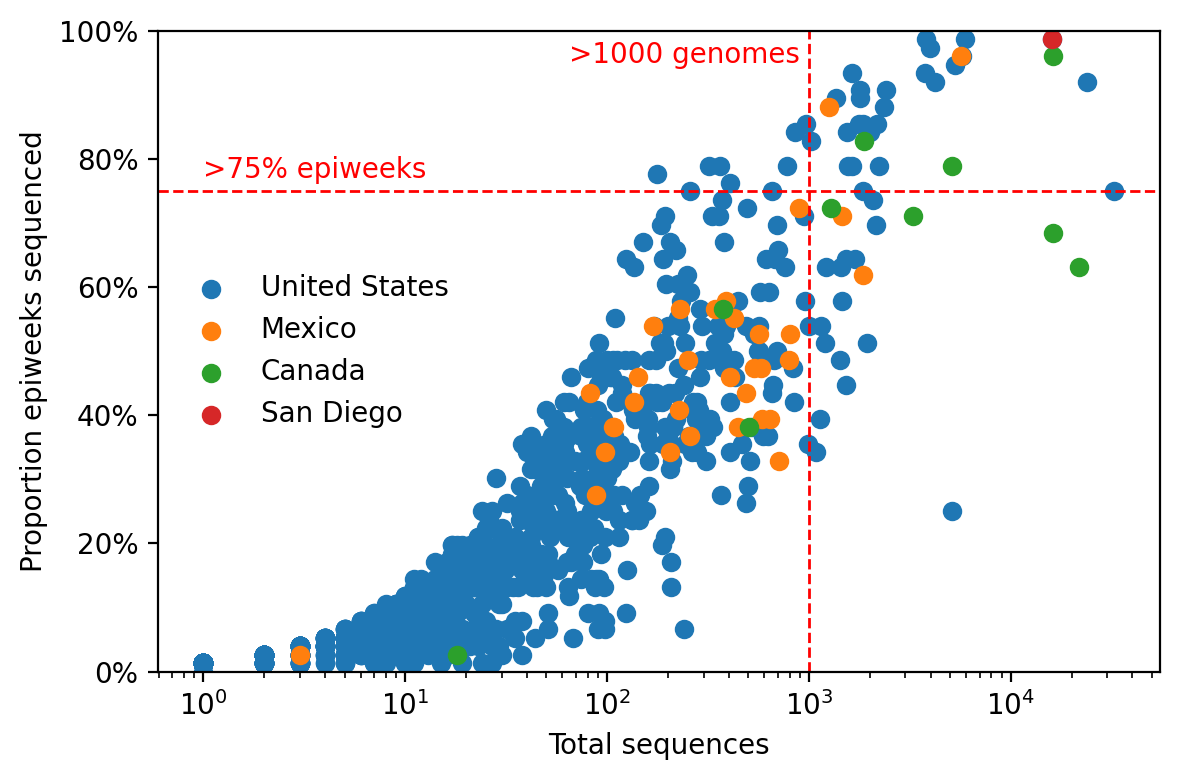

In [33]:
fig, ax = plt.subplots( dpi=200, figsize=(6,4) )

ax.scatter( "sequences", "completeness", data=summary.loc[namd.loc[namd["country"]=="USA","site"].unique()], label="United States" )
ax.scatter( "sequences", "completeness", data=summary.loc[namd.loc[namd["country"]=="Mexico","site"].unique()], label="Mexico" )
ax.scatter( "sequences", "completeness", data=summary.loc[namd.loc[namd["country"]=="Canada","site"].unique()], label="Canada" )
ax.scatter( "sequences", "completeness", data=summary.loc["San Diego County"], label="San Diego" )
ax.set_ylabel( "Proportion epiweeks sequenced" )
ax.set_xlabel( "Total sequences" )
ax.axvline( 1000, linestyle="dashed", linewidth=1, color="red" )
ax.axhline( 0.75, linestyle="dashed", linewidth=1, color="red" )
ax.text( 900, 0.95, ">1000 genomes", ha="right", color="red" )
ax.text( 1, 0.77, ">75% epiweeks", color="red" )
ax.set_xscale( "log" )
ax.yaxis.set_major_formatter( PercentFormatter(1, 0) )
ax.set_ylim(0,1)
ax.legend( frameon=False )
plt.tight_layout()
plt.show()

In [66]:
summary.loc[(summary["completeness"]>0.75)&(summary["sequences"]>1000)]

,sequences,completeness
New York City,23907,0.921053
Quebec,16232,0.960526
San Diego County,15963,0.986842
Santa Clara County,5901,0.986842
Los Angeles County,5748,0.960526
Mexico City,5678,0.960526
Maricopa County,5276,0.947368
Saskatchewan,5131,0.789474
Alameda County,4195,0.921053
Cook County IL,3978,0.973684


In [35]:
namd.loc[namd["site"]=="King County","division"].value_counts()

Washington    3804
Name: division, dtype: int64